In [1]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from mrio import dicom_reader,nifti_reader
from models.roi import create_rois, ROI  # Import create_rois and ROI class
from fitting.relaxation_fitting import RelaxationFittingModel
from process import transform,transform_mask
from fitting.analysis import compute_roi_statistics
from visualization.mapplot import (
    show_slice,
    show_mask,
    show_parameter_map_with_rois,
    show_rois_with_mean,
)

In [2]:
input_dicom_folder_1 = '/home/gizmoo/Desktop/C01/CHockey_01_T0_l/DICOM_translated/MRTC-Studie_Hockey_K01_GAPF81827/20210907_1825/6_t2_de3d_we_cor_11121'
input_mask_file= '/home/gizmoo/Desktop/C01/masks/Cor_Maske_C01_T0_l_04092024_1321.nii.gz'
input_dicom_folder_2 = '/home/gizmoo/Desktop/C01/CHockey_01_T0_l/DICOM_translated/MRTC-Studie_Hockey_K01_GAPF81827/20210907_1825/7_T2-star_map_3D_cor_12541'
out_nii_file = '/home/gizmoo/new_mask.nii.gz'

In [3]:
# Convert the paths to Path objects
mask = transform_mask(
        input_dicom_folder_1=Path(input_dicom_folder_1),
        input_mask_file=Path(input_mask_file),
        input_dicom_folder_2=Path(input_dicom_folder_2),        
    )
print(f"Segmentation Size: {mask.GetSize()}")

labels = np.unique( sitk.GetArrayFromImage(mask))
print(labels)

Segmentation Size: (256, 256, 96)
[0 1 2 3 4]


In [4]:
images, echos = dicom_reader.read_multiple_echos_one_folder(input_dicom_folder_2)
print("Echo Times:", echos)
print(f"Segmentation Size: {images[0].GetSize()}")


Echo Times: [4.62, 9.41, 15.28, 21.15, 27.02, 32.89]
Segmentation Size: (256, 256, 96)


In [5]:
labels = list(range(1,5))
rois = create_rois(mask, images[0], labels)
print(f"Number of ROIs Created: {len(rois)}")
print(labels)

Number of ROIs Created: 4
[1, 2, 3, 4]


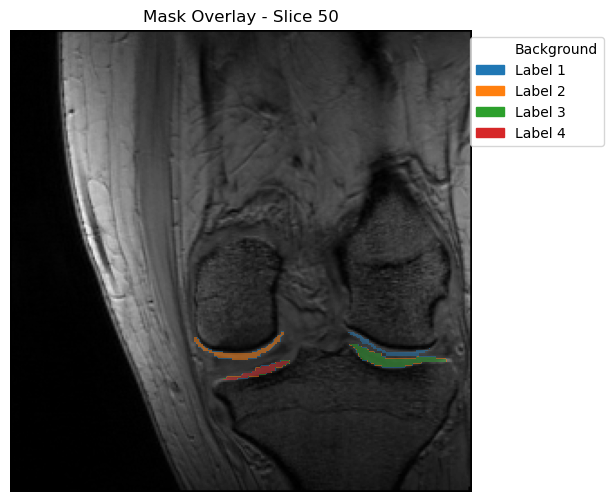

In [6]:
slice_index = 50  # Adjust based on your data
show_mask(
    image=images[0],
    rois=rois,
    slice_index=slice_index,
    title=f"Mask Overlay - Slice {slice_index}",
    alpha=0.5
)

In [7]:
relaxation = 'T2*'
fitting_model = RelaxationFittingModel(time_values= echos,model_type=relaxation)

In [8]:
# Fit T2 curve for each ROI
for roi in rois:
    print(f"Fitting T2 curve for Label {roi.label_id}...")
    roi.fit(images=images,fitting_model= fitting_model)
    roi.compute_statistics()
    print(f"Label {roi.label_id} - Mean T2: {roi.mean:.2f} ms, Std T2: {roi.std:.2f} ms")

Fitting T2 curve for Label 1...
Label 1 - Mean T2: 34.25 ms, Std T2: 11.71 ms
Fitting T2 curve for Label 2...
Label 2 - Mean T2: 26.08 ms, Std T2: 9.81 ms
Fitting T2 curve for Label 3...
Label 3 - Mean T2: 23.90 ms, Std T2: 10.14 ms
Fitting T2 curve for Label 4...
Label 4 - Mean T2: 24.26 ms, Std T2: 9.08 ms


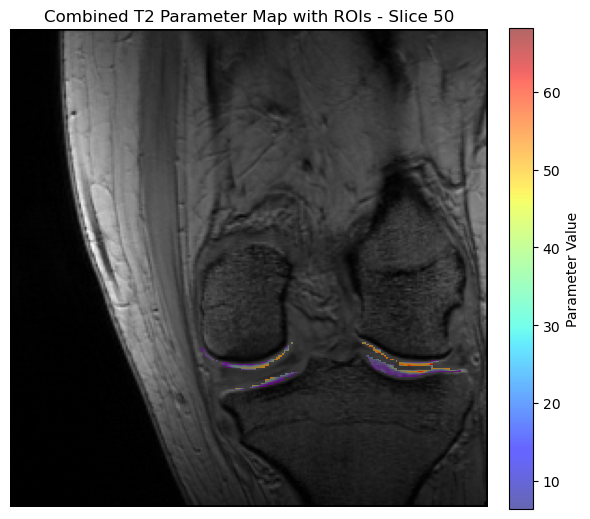

In [9]:
# Visualize the combined T2 Parameter Map with all ROIs
show_parameter_map_with_rois(
    image=images[0],
    rois=rois,
    slice_index=slice_index,  # Adjust based on your data
    title=f"Combined T2 Parameter Map with ROIs - Slice {slice_index}",
    cmap_param='jet',       # Choose an appropriate colormap
    alpha_param=0.6,       # Adjust transparency as needed
    cmap_roi='autumn',     # Choose an appropriate colormap for ROIs
    alpha_roi=0.3,         # Adjust transparency as needed
    save_path=None# Ensure 'visualization/' exists
)

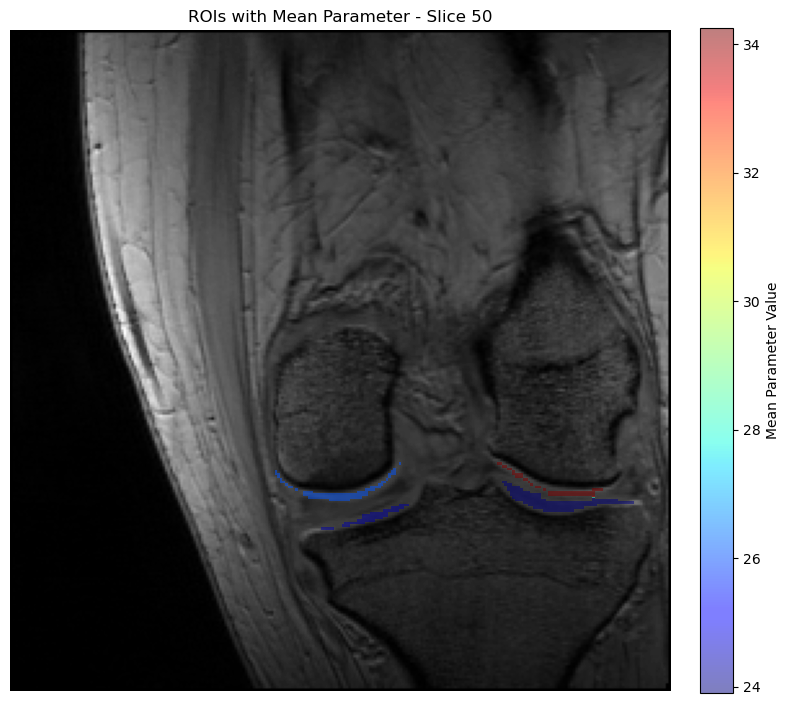

In [10]:
show_rois_with_mean(
    image=images[0],
    rois=rois,
    slice_index=slice_index,
    title=f"ROIs with Mean Parameter - Slice {slice_index}",
    cmap= 'jet',
    alpha=0.5,
    save_path=None
)